## The Big Wave
Progect Leads: Trevor McLean, Avery Meyers

We will be doing a case study excersise in simplifying and visually representing the progression and creation of three tsunamis through
an analysis of the water level data from several stations. We will be creating a map with the three epicenters and locations of stations 
from which the data was obtained, as well as radius rings from the epicenters of amplitude at distance. As well we have a bar graph of 
the high points of amplitude for all three tsunamis against one another for the first 30 min range after start. And lastly we will have 
graphs of general data about the water level caused by the tsunamis obtained from the stations. (We may have a dedicated graph for
representing amplitude over time for all three tsunamis together to highlight patterns.)

Data of water level from three stations per tsunami will be necessary, as well as general history and general statistics about the tsunamis and their effects. The only resultant data would be a progression of amplitude form epicenter for each tsunami.

The numpy, matplotlib, datetime, and mpl_toolkits.basemap modules will be necessary.

I expect the project will take about 20 man-hours.

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2index


def read_data(f_name):
    '''(str) -> (list, list)
    
    Takes in a file of primary water levels against time and parses the data into
    two lists: a list of times and a list of primary water level(pwl). Returns those
    lists in a tuple.
    '''
    with open(f_name, 'r') as f_temp:
        f_temp.readline()
        f_temp.readline()
        L_time = []
        L_pwl = []
        
        for i in f_temp:
            L_temp = i.strip().split('\t')
            L_time.append(L_temp[0])
            L_pwl.append(float(L_temp[1]))
                         
    return L_time, L_pwl


def read_lat_lon(name):
    with open(name, 'r') as f:
        f.readline()
        stations = {}
        for l in f:
            temp_l = l.strip().split(',')
            stations[temp_l[0]] = (float(temp_l[1]), float(temp_l[2]))
        return stations
            

                         
def data_point_time(L_time):
    '''(list) -> list
    
    Takes in a list of times L_times in the formal of files from the IOC and reduces it down
    to a series of integers representative of the amount of minutes that have passed at any 
    given point. Returns a list of equal length that contains float quantities of minutes 
    passed.
    
    >>> data_point_time(['2011-03-11 00:05:00', '2011-03-11 01:23:00'])
    [5, 83]
    >>> data_point_time(['2011-03-11 00:00:00', '2011-03-11 01:23:00', '2011-03-11 01:23:00', '2011-03-11 01:23:00'])
    [0, 83, 83, 83]
    '''
    
    L_time_initial = L_time[0]
    format_time = L_time_initial.split()
    format_time_list = format_time[0].split('-') + format_time[1].split(':')
    base_time = dt.datetime(year=int(format_time_list[0]),
                            month=int(format_time_list[1]),
                            day=int(format_time_list[2]), 
                            hour=int(format_time_list[3]), 
                            minute=int(format_time_list[4])
                           )
    
    L_time_minutes = []
    for time in L_time:
        temp_time = time.split()
        temp_time_list = temp_time[0].split('-') + temp_time[1].split(':')
        current_time = dt.datetime(year=int(temp_time_list[0]),
                                    month=int(temp_time_list[1]),
                                    day=int(temp_time_list[2]), 
                                    hour=int(temp_time_list[3]), 
                                    minute=int(temp_time_list[4])
                                   )
        time_difference = (current_time - base_time).total_seconds() / 60
        L_time_minutes.append(time_difference)
        
    return L_time_minutes

def calculate_amplitudes(L_time, L_pwl):
    '''(list, list) -> dict
    
    Takes in a list of times L_time and a list of precision water levels L_pwl and calculates
    a right-side amplitude approximation for every wave of the plot. Returns those amplitudes
    as values paired with a key of the time of the peak for each amplitude in a dictionary.
    '''
    
    start = 0
    end = 0
    amplitudes = {}
    for i in range(1, len(L_pwl)):
        if (len(L_pwl) - 1) == i:
            break
            
        if L_pwl[i] < L_pwl[i+1] and L_pwl[i-1] >= L_pwl[i]:
            start = L_pwl[i]
        elif L_pwl[i] > L_pwl[i+1] and L_pwl[i-1] <= L_pwl[i]:
            end = L_pwl[i]
            peak = i
            
        if start and end:
            amplitudes[L_time[peak]] = 100 * round(((end - start) / 2), 4)
            start = 0
            end = 0
            
    return amplitudes

def find_start(time_list, pwl_list):
    '''
    (list, list) -> num

    Takes in a list of times and percision water levels and returns an index on the x axis where 
    the start of a tsunami event can be graphed.

    '''
    running_avg = 0
    last_total = 0
    for i in range(1, len(pwl_list)):
        diff = abs(pwl_list[i] - pwl_list[i-1])
        if i > 30:
            if diff > running_avg*6:
                return time_list[i]
            else:
                last_total = last_total + diff
                running_avg = last_total/i
        else: 
            last_total = last_total + diff
            running_avg = last_total/i
    return None

def determine_max(amplitudes):
    
    max_amps = []
    for amps in amplitudes:
        ctr = 0
        for time in amps:
            if amps[time] > ctr:
                ctr = amps[time]
        max_amps.append(ctr)
            
    return max_amps
        
    
def amps_combiner(tsunami_name, L_station_names, L_amps):
    
    tsunami_container = {}
    assoc_container = {}
    for i in range(len(L_station_names)):
        assoc_container[L_station_names[i]] = L_amps[i]
    tsunami_container[tsunami_name] = assoc_container
    return tsunami_container

def find_distance(epilat, epilon, stations):
    
    #In Kilometers
    R = 6373.0

    lat1 = math.radians(epilat)
    lon1 = math.radians(epilon)

    distances = []

    for station in stations:
        lat2 = math.radians(station[0])
        lon2 = math.radians(station[1])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        #Haversine formula
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c
        distances.append(distance)
    return distances


#### Info gathered from(primarily) USGS.gov and sms-tsunami-warning.com
#### Data gathered from ioc-sealevelmonitoring.org

Tsunamis are large waves caused primarily by earthquakes or other phenomenons of ocean water shifting such as from coastal land-slides and techtonic shifts. 
The term tsunami was adapted from japanese at around world war 2. 'Tsu' meaning harbor and 'Nami' meaning wave.

##### Japan 2011, Miyagi Prefecture Tsunami: Caused by a 9.0 magnitude undersea earthquake on March 11 
##### Chile 2010, Maule: Caused by a 8.8 magnitude earthquake on February 27 
##### Solomon Islands, Lata 2013: Caused by a 8.0 magnitude earthquake on February 06 

{5.0: 0.15, 13.0: 3.66, 25.0: 0.45999999999999996, 32.0: 0.15, 37.0: 0.15, 47.0: 0.45999999999999996, 57.0: 0.3, 62.0: 0.15, 64.0: 2.9000000000000004, 73.0: 0.61, 79.0: 0.3, 81.0: 3.04, 88.0: 0.45999999999999996, 90.0: 0.3, 101.0: 0.15, 103.0: 0.3, 113.0: 0.15, 133.0: 0.3, 137.0: 2.2800000000000002, 150.0: 0.3, 164.0: 0.3, 167.0: 0.15, 171.0: 0.15, 173.0: 5.489999999999999, 194.0: 0.44999999999999996, 203.0: 0.15, 222.0: 0.31, 229.0: 1.22, 233.0: 2.2800000000000002, 240.0: 0.44999999999999996, 247.0: 0.45999999999999996, 255.0: 0.44999999999999996, 258.0: 0.15, 263.0: 2.13, 278.0: 3.2, 288.0: 0.3, 295.0: 0.91, 297.0: 0.45999999999999996, 299.0: 0.15, 305.0: 3.35, 320.0: 0.61, 322.0: 0.15, 327.0: 0.61, 336.0: 1.68, 342.0: 0.45999999999999996, 345.0: 0.45999999999999996, 348.0: 0.45999999999999996, 352.0: 0.3, 355.0: 1.06, 363.0: 0.45999999999999996, 366.0: 1.68, 371.0: 1.06, 373.0: 3.05, 375.0: 1.67, 378.0: 3.2, 380.0: 2.44, 382.0: 2.1399999999999997, 384.0: 1.53, 386.0: 2.9000000000000

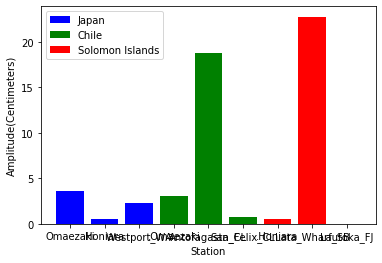

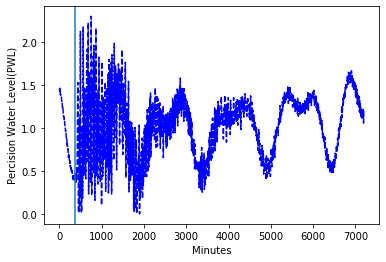

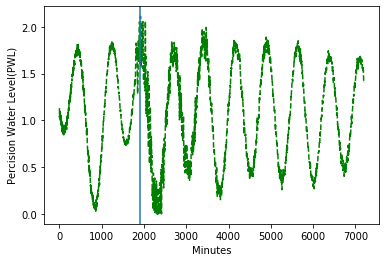

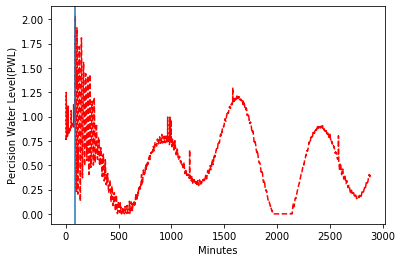

In [17]:
def plot_variation(time_lists, pwl_lists):
    '''(list(lists), list(lists)) -> None
    
    Graphs a representation of the water level change over time for multiple different sets of data. 
    Takes in twp lists of lists where each internal list of the list time_lists is the times of data collection
    converted to minutes by the function data_point_time. The list pwl_lists contains lists of precision water level
    associated with the respective index of list of time points. This function returns none and prints all given 
    pairs of time and pwl lists. There must be equal amounts of lists in time_lists and pwl_lists. As well, those
    lists must be of equal length.
    '''
    L_pwls = pwl_lists.copy()
    L_diffs = []

    '''
    for pwl_list in pwl_lists:
        temp_diffs = [0]
        for i in range(1, len(pwl_list)):
            diff = abs(pwl_list[i] - pwl_list[i-1])
            temp_diffs.append(diff)
            
        L_diffs.append(temp_diffs)
    '''
    #Ignore the above. It was a failed attempt at representing the rate of fluctuation. I may revisit a similar idea so the code remains.
    
    colors = ['b', 'g', 'r']
    
    for i in range(len(time_lists)):
        plt.figure()
        plt.plot(np.array(time_lists[i]), np.array(pwl_lists[i]), colors[i] + '--') 
        plt.axvline(find_start(time_lists[i], pwl_lists[i]))
        plt.xlabel('Minutes')
        plt.ylabel('Percision Water Level(PWL)')
 
def plot_amp_max_per_tsunami(L_maxamps_lists, L_station_names_per_tsunami, L_tsunami_names, L_color_code):
    
    maxapms = [[] + n for n in L_maxamps_lists]
    stations = [[] + n for n in L_station_names_per_tsunami]
   
    plt.figure()
    plt.xlabel('Station')
    plt.ylabel('Amplitude(Centimeters)')
    for i in range(len(L_tsunami_names)):
        plt.bar(L_station_names_per_tsunami[i], L_maxamps_lists[i], label = L_tsunami_names[i], color = L_color_code[i])
    plt.legend()
    plt.show()
 
def hell(d_latlon_data, d_tsunamis):
    
    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    m = Basemap(projection = 'merc', llcrnrlat = -80, urcrnrlat = 80, llcrnrlon = -180, urcrnrlon = 180, lat_ts = 20, resolution = 'c', lat_0=0, lon_0=0)

    m.drawcoastlines()
    m.drawmapboundary(fill_color = 'aqua')
    m.fillcontinents(color = 'black')
    
    
    colors1= ['b', 'g', 'r']
    colors2= ['darkblue', 'darkgreen', 'darkred']
    for tsunami in d_tsunamis:
        station_list = []
        amps_list = []
        lats = []
        lons = []
        for station in d_tsunamis[tsunami]:
            station_list.append(station)
            print(station_list)
            amps_list.append(d_tsunamis[tsunami][station])
            lons.append(d_latlon_data[station][0])
            lats.append(d_latlon_data[station][1])
        x, y = map(lons, lats)
        m.scatter(x, y, marker='C', color=colors1.pop())
        
        x2, y2 = map(d_latlon_data[tsunami][0], d_latlon_data[tsunami][1])
        m.plot(x2, y2, marker='D', color=colors2.pop())
    
    plt.show()


        
t1_1, pwl1_1 = read_data('Japan(Omaezaki).txt')
t1_2, pwl1_2 = read_data('Japan(Honiara).txt')
t1_3, pwl1_3 = read_data('Japan(Westport_WA).txt')

minutes1_1 = data_point_time(t1_1)
minutes1_2 = data_point_time(t1_2)
minutes1_3 = data_point_time(t1_3)

amps1_1 = calculate_amplitudes(minutes1_1, pwl1_1)
print(amps1_1)
amps1_2 = calculate_amplitudes(minutes1_2, pwl1_2)
amps1_3 = calculate_amplitudes(minutes1_3, pwl1_3)

amp1 = determine_max([amps1_1,amps1_2,amps1_3])
print(amp1)

t2_1, pwl2_1 = read_data('Chile(Omaezaki).txt')
t2_2, pwl2_2 = read_data('Chile(Antofagasta_CL).txt')
t2_3, pwl2_3 = read_data('Chile(San_Felix_CL).txt')

minutes2_1 = data_point_time(t2_1)
minutes2_2 = data_point_time(t2_2)
minutes2_3 = data_point_time(t2_3)

amps2_1 = calculate_amplitudes(minutes2_1, pwl2_1)
amps2_2 = calculate_amplitudes(minutes2_2, pwl2_2)
amps2_3 = calculate_amplitudes(minutes2_3, pwl2_3)

amp2 = determine_max([amps2_1,amps2_2,amps2_3])

t3_1, pwl3_1 = read_data('Solomon_Islands(Honiara).txt')
t3_2, pwl3_2 = read_data('Solomon_Islands(Lata_Wharf_SB).txt')
t3_3, pwl3_3 = read_data('Solomon_Islands(Lautoka_FJ).txt')

minutes3_1 = data_point_time(t3_1)
minutes3_2 = data_point_time(t3_2)
minutes3_3 = data_point_time(t3_3)

amps3_1 = calculate_amplitudes(minutes3_1, pwl3_1)
amps3_2 = calculate_amplitudes(minutes3_2, pwl3_2)
amps3_3 = calculate_amplitudes(minutes3_3, pwl3_3)

amp3 = determine_max([amps3_1,amps3_2,amps3_3])

japan_dict = amps_combiner("Japan 2011", ['Omaezaki', 'Honiara', 'Westport WA'], amp1)
chile_dict = amps_combiner("Chile 2010", ['Omaezaki', 'Antofagasta CL', 'San Felix'], amp2)
solomon_dict = amps_combiner("Solomon Islands 2013", ['Honiara', 'Lata Wharf SB', 'Lautoka FJ'], amp3)

tsunami_dict = {**japan_dict, **chile_dict, **solomon_dict}


#hell(read_lat_lon('Lat_Lon.txt'), tsunami_dict)


plot_amp_max_per_tsunami([amp1, amp2, amp3], 
                         [['Omaezaki', 'Honiara', 'Westport_WA'], ['.Omaezaki', 'Antofagasta_CL', 'San_Felix_CL'], ['.Honiara', 'Lata_Wharf_SB', 'Lautoka_FJ']],
                         ['Japan', 'Chile', 'Solomon Islands'], 
                         ['b', 'g', 'r'])
plot_variation([minutes1_1, minutes2_1, minutes3_2], [pwl1_1, pwl2_1, pwl3_2])

The above data displays the original behavior of the wave data. Though the points in time that they began is inconsistant, there is still an interesting similarity between each graph as once the event begins, instead of just causing quite high water levels, it instead causes a fluxuation to really high water levels, then to exceptionally low water levels. This as well seems to be following a general trend of shape of the standard fluctuations of water level. This is likely due to the tsunami fluxuations being an alteration of a consistant change in normal tide, meaning that the tide still follows normal behaviour in spite of the tsunami. I may write a function in future to remove the tide change aspect from the graph so that the specific fluctuations of the tsunami can be isolated.